In [1]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Tuple, Callable
from openai import OpenAI
from textblob import TextBlob
import re
from datetime import datetime, date  # Added date import
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
import logging
import traceback
from io import StringIO
from contextlib import redirect_stdout
import time

In [2]:

class DynamicTool:
    def __init__(self, name: str, description: str, llm_client):
        self.name = name
        self.description = description
        self.client = llm_client
        self.execution_steps = []
        self.last_code = None
        self.last_result = None
        self.execution_time = 0

    def extract_code(self, text: str) -> str:
        """Extract only the Python code from the response"""
        # If code is wrapped in markdown code blocks, extract it
        if '```python' in text and '```' in text:
            code_blocks = text.split('```')
            for block in code_blocks:
                if block.startswith('python'):
                    return block.replace('python', '').strip()
                elif not any(block.startswith(lang) for lang in ['bash', 'javascript', 'json']):
                    if block.strip():  # If block is not empty
                        return block.strip()
        # If no markdown blocks, try to find code after common prefixes
        prefixes = [
            "Here's the code:",
            "Here is the code:",
            "Here's the Python code:",
            "Here is the Python code:",
            "The code would be:",
        ]
        for prefix in prefixes:
            if prefix in text:
                return text.split(prefix)[1].strip()
        
        # If no prefixes found, assume the entire response is code
        return text.strip()

    def generate_code(self, query: str, context: Dict = None) -> str:
        base_prompt = "Generate ONLY Python code (no explanations or text) for the following task:\n"
        task_desc = f"Task: {self.description}\n"
        query_desc = f"Query: {query}\n"
        context_desc = f"Available data in DataFrame 'df' with columns: {context.get('columns', [])}\n"
        
        requirements = """
        Requirements:
        1. Return ONLY the Python code, no explanations or text
        2. Use pandas, numpy, matplotlib, seaborn
        3. Include print statements for progress tracking
        4. Store results in 'results' dictionary
        5. Handle errors with try-except
        6. Create visualizations when relevant
        """
        
        example = """
        Example format:
        try:
            results = {}
            
            # Your code here
            # ...
            
            plt.figure(figsize=(10, 6))
            # Visualization code...
            plt.show()
            
            results['metric_name'] = value
        except Exception as e:
            print(f"Error: {str(e)}")
            results = {'error': str(e)}
        """
        
        prompt = base_prompt + task_desc + query_desc + context_desc + requirements + example

        response = self.client.chat.completions.create(
            model="gpt-4",
            messages=[{
                "role": "user", 
                "content": prompt
            }],
            temperature=0.7
        )
        
        code = self.extract_code(response.choices[0].message.content)
        self.last_code = code
        return code

    def execute(self, code: str, context: Dict) -> Dict:
        """Execute generated code safely with result serialization"""
        start_time = time.time()
        output = StringIO()
        
        try:
            with redirect_stdout(output):
                # Prepare execution environment
                local_vars = {
                    'df': context['df'],
                    'pd': pd,
                    'np': np,
                    'plt': plt,
                    'sns': sns,
                    'results': {}
                }
                
                exec(code, local_vars)
                
                # Get results and serialize them
                results = local_vars.get('results', {})
                serialized_results = {}
                for k, v in results.items():
                    if isinstance(v, (pd.DataFrame, pd.Series)):
                        serialized_results[k] = v.to_dict()
                    elif isinstance(v, np.ndarray):
                        serialized_results[k] = v.tolist()
                    elif isinstance(v, (datetime, date)):
                        serialized_results[k] = v.isoformat()
                    else:
                        serialized_results[k] = v

                # Create result dictionary
                result = {
                    'execution_time': time.time() - start_time,
                    'output': output.getvalue(),
                    'results': serialized_results
                }
                self.last_result = result
                return result
                
        except Exception as e:
            error_result = {
                'error': str(e),
                'traceback': traceback.format_exc(),
                'execution_time': time.time() - start_time,
                'output': output.getvalue()
            }
            self.last_result = error_result
            return error_result



class CustomerSupportAgent:
    def __init__(self, api_key: str, dataset_path: str):
        """Initialize the customer support agent with OpenAI API key and dataset."""
        self.client = OpenAI(api_key=api_key)
        self.df = pd.read_csv(dataset_path, sep='\t', on_bad_lines='skip', encoding='utf-8')
        print(f"Dataset shape: {self.df.shape}")
        print("Columns:", self.df.columns.tolist())
        
        # Initialize dynamic tools
        self.dynamic_tools = {
            'search_products': DynamicTool(
                'search_products',
                'Search and analyze products based on query criteria',
                self.client
            ),
            'get_product_stats': DynamicTool(
                'get_product_stats',
                'Generate statistical analysis of products',
                self.client
            )
        }
        
        # Keep existing tools for other functionalities
        self.tools = {
            'analyze_sentiment': self.analyze_sentiment,
            'generate_response': self.generate_response
        }
        
        # Add execution tracking
        self.execution_history = []

    def decide_tool(self, query: str) -> str:
        prompt = f"""Given the following query, which tool should be used?
        Query: {query}
        Available tools:
        - search_products: for finding specific products or similar products
        - analyze_sentiment: for analyzing review sentiments
        - get_product_stats: for getting statistical information about products
        - generate_response: for generating customer support responses
        Return only the tool name without explanation."""
        
        response = self.client.chat.completions.create(  # Updated API call
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content.strip()

    def search_products(self, query: str, n_results: int = 5) -> List[Dict]:
        tfidf = TfidfVectorizer(stop_words='english')
        product_desc = self.df['product_title'].fillna('') + ' ' + self.df['review_body'].fillna('')
        tfidf_matrix = tfidf.fit_transform(product_desc)
        query_vec = tfidf.transform([query])
        similarities = cosine_similarity(query_vec, tfidf_matrix)
        
        top_indices = similarities[0].argsort()[-n_results:][::-1]
        results = []
        for idx in top_indices:
            results.append({
                'product_title': str(self.df.iloc[idx]['product_title']),
                'rating': float(self.df.iloc[idx]['star_rating']),
                'review': str(self.df.iloc[idx]['review_body'])
            })
        return results


    def analyze_sentiment(self, query: str) -> Dict:
        """
        Enhanced sentiment analysis that handles natural language queries for sentiment analysis.
        """
        try:
            # Extract product category or name from query using simple keyword matching
            query = query.lower()
            
            # Extract product term from query
            if 'for' in query:
                product_term = query.split('for')[-1].strip()
            else:
                product_term = query

            # Filter relevant reviews
            mask = self.df['product_title'].str.lower().str.contains(product_term, na=False) | \
                self.df['product_category'].str.lower().str.contains(product_term, na=False)
            reviews_df = self.df[mask].copy()

            if len(reviews_df) == 0:
                return {"error": f"No reviews found for '{product_term}'"}

            print(f"Analyzing {len(reviews_df)} reviews for '{product_term}'")

            # Convert review_date to datetime and ensure it's sorted
            reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'])
            reviews_df = reviews_df.sort_values('review_date')
            
            # Calculate sentiment scores
            from textblob import TextBlob
            reviews_df['sentiment_score'] = reviews_df['review_body'].fillna('').apply(
                lambda x: TextBlob(str(x)).sentiment.polarity
            )

            # 1. Generate Word Cloud
            try:
                from wordcloud import WordCloud
                from nltk.corpus import stopwords
                from collections import Counter
                
                # Combine all reviews
                text = ' '.join(reviews_df['review_body'].fillna(''))
                stop_words = set(stopwords.words('english'))
                
                # Create and generate word cloud
                wordcloud = WordCloud(
                    width=800, height=400,
                    background_color='white',
                    max_words=100,
                    stopwords=stop_words
                ).generate(text)
                
                # Calculate word frequencies
                words = text.lower().split()
                word_freq = Counter([word for word in words 
                                if word not in stop_words and len(word) > 3])
                
            except Exception as e:
                print(f"Warning: Word cloud generation failed: {str(e)}")
                wordcloud = None
                word_freq = Counter()

            # 2. Time Trend Analysis
            daily_sentiment = reviews_df.set_index('review_date')['sentiment_score'].resample('D').mean()
            moving_avg = daily_sentiment.rolling(window=7, min_periods=1).mean()

            # 3. Calculate Customer Satisfaction Metrics
            total_responses = len(reviews_df)
            satisfaction_metrics = {
                'average_rating': float(reviews_df['star_rating'].mean()),
                'rating_distribution': reviews_df['star_rating'].value_counts().to_dict(),
                'total_reviews': total_responses,
                'verified_purchases': int(reviews_df['verified_purchase'].value_counts().get('Y', 0)),
                'helpful_votes_total': int(reviews_df['helpful_votes'].sum())
            }

            # Create visualizations
            plt.figure(figsize=(20, 12))
            
            # 1. Word Cloud
            if wordcloud:
                plt.subplot(2, 2, 1)
                plt.imshow(wordcloud)
                plt.axis('off')
                plt.title(f'Word Cloud: {product_term.title()} Reviews')
            
            # 2. Sentiment Trends
            plt.subplot(2, 2, 2)
            plt.plot(daily_sentiment.index, daily_sentiment.values, label='Daily Sentiment', alpha=0.5)
            plt.plot(moving_avg.index, moving_avg.values, label='7-Day Average', linewidth=2)
            plt.title(f'Sentiment Trends: {product_term.title()}')
            plt.xlabel('Date')
            plt.ylabel('Sentiment Score')
            plt.legend()
            
            # 3. Rating Distribution
            plt.subplot(2, 2, 3)
            rating_dist = reviews_df['star_rating'].value_counts().sort_index()
            rating_dist.plot(kind='bar')
            plt.title('Rating Distribution')
            plt.xlabel('Star Rating')
            plt.ylabel('Number of Reviews')
            
            # 4. Sentiment Distribution
            plt.subplot(2, 2, 4)
            reviews_df['sentiment_category'] = pd.cut(
                reviews_df['sentiment_score'],
                bins=[-1, -0.2, 0.2, 1],
                labels=['Negative', 'Neutral', 'Positive']
            )
            sentiment_dist = reviews_df['sentiment_category'].value_counts()
            plt.pie(sentiment_dist.values, labels=sentiment_dist.index, autopct='%1.1f%%')
            plt.title('Sentiment Distribution')
            
            plt.tight_layout()
            plt.show()

            # Return comprehensive analysis
            return {
                'summary': {
                    'total_reviews': total_responses,
                    'average_rating': satisfaction_metrics['average_rating'],
                    'verified_purchase_percentage': 
                        satisfaction_metrics['verified_purchases'] / total_responses * 100,
                    'sentiment_summary': {
                        'positive': len(reviews_df[reviews_df['sentiment_score'] > 0.2]),
                        'neutral': len(reviews_df[
                            (reviews_df['sentiment_score'] >= -0.2) & 
                            (reviews_df['sentiment_score'] <= 0.2)
                        ]),
                        'negative': len(reviews_df[reviews_df['sentiment_score'] < -0.2])
                    }
                },
                'word_analysis': {
                    'top_words': dict(word_freq.most_common(20))
                },
                'sentiment_trends': {
                    'current_sentiment': float(daily_sentiment.iloc[-1]) if len(daily_sentiment) > 0 else 0,
                    'overall_trend': 'improving' if len(daily_sentiment) > 1 and 
                        daily_sentiment.iloc[-1] > daily_sentiment.iloc[0] else 'declining',
                    'latest_week_average': float(moving_avg.iloc[-1]) if len(moving_avg) > 0 else 0
                },
                'satisfaction_metrics': satisfaction_metrics
            }

        except Exception as e:
            print(f"Error in enhanced sentiment analysis: {str(e)}")
            return {"error": str(e)}
    



    def get_product_stats(self, product_id: str = None) -> Dict:
        if product_id:
            product_data = self.df[self.df['product_id'] == product_id]
        else:
            product_data = self.df

        stats = {
            "average_rating": float(product_data['star_rating'].mean()),
            "total_reviews": len(product_data),
            "verified_purchases": product_data['verified_purchase'].value_counts().to_dict(),
            "rating_distribution": product_data['star_rating'].value_counts().to_dict()
        }
        return stats

    def generate_response(self, query: str, context: Dict = None) -> str:
        prompt = f"""As a customer support agent, provide a helpful response to the following query.
        Query: {query}
        Context: {json.dumps(context) if context else 'No additional context provided'}
        Response should be professional and helpful."""

        response = self.client.chat.completions.create(  # Updated API call
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}]
        )
        return response.choices[0].message.content

    def process_query(self, query: str) -> Dict:
        execution_record = {
            'query': query,
            'timestamp': datetime.now().isoformat(),
            'steps': []
        }
        
        try:
            # Step 1: Tool Selection
            tool_selection_start = time.time()
            selected_tool = self.decide_tool(query)
            execution_record['steps'].append({
                'step': 'tool_selection',
                'tool': selected_tool,
                'time': time.time() - tool_selection_start
            })
            
            # Step 2: Tool Execution
            if selected_tool in self.dynamic_tools:
                # Use dynamic tool
                tool = self.dynamic_tools[selected_tool]
                
                # Generate code
                code_gen_start = time.time()
                code = tool.generate_code(query, {'df': self.df, 'columns': self.df.columns})
                execution_record['steps'].append({
                    'step': 'code_generation',
                    'code': code,
                    'time': time.time() - code_gen_start
                })
                
                # Execute code
                execution_start = time.time()
                result = tool.execute(code, {'df': self.df})
                execution_record['steps'].append({
                    'step': 'execution',
                    'result': result,
                    'time': time.time() - execution_start
                })
            else:
                # Use existing tools
                execution_start = time.time()
                if selected_tool == 'analyze_sentiment':
                    result = self.analyze_sentiment(query)
                else:
                    result = self.generate_response(query)
                    
                execution_record['steps'].append({
                    'step': 'execution',
                    'result': result,
                    'time': time.time() - execution_start
                })
            
            execution_record['success'] = True
            execution_record['result'] = result
            
        except Exception as e:
            execution_record['success'] = False
            execution_record['error'] = str(e)
            execution_record['traceback'] = traceback.format_exc()
            
        self.execution_history.append(execution_record)
        return execution_record
    

    def get_execution_history(self) -> List[Dict]:
        """Get execution history with step details"""
        return [{
            'query': record['query'],
            'timestamp': record['timestamp'],
            'success': record.get('success', False),
            'steps': [{'step': s['step'], 'time': s['time']} for s in record['steps']],
            'total_time': sum(s['time'] for s in record['steps'])
        } for record in self.execution_history]
    

    # Add this helper function to the CustomerSupportAgent class
    def _serialize_results(self, obj):
        """Helper function to make results JSON serializable"""
        if isinstance(obj, (pd.DataFrame, pd.Series)):
            return obj.to_dict()
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (datetime, date)):
            return obj.isoformat()
        elif isinstance(obj, dict):
            return {k: self._serialize_results(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._serialize_results(item) for item in obj]
        elif isinstance(obj, (int, float, str, bool, type(None))):
            return obj
        else:
            return str(obj)

    def visualize_execution(self, execution_record: Dict):
        """Visualize execution steps and results with proper serialization"""
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Execution Timeline
        plt.subplot(2, 1, 1)
        steps = execution_record.get('steps', [])
        labels = [step['step'] for step in steps]
        times = [step.get('time', 0) for step in steps]
        
        plt.barh(range(len(steps)), times)
        plt.yticks(range(len(steps)), labels)
        plt.xlabel('Time (seconds)')
        plt.title('Execution Timeline')
        
        # Plot 2: Tool Outputs
        plt.subplot(2, 1, 2)
        if execution_record.get('success', False):
            result = execution_record.get('result', {})
            if isinstance(result, dict):
                # Serialize results for display
                serialized_results = self._serialize_results(result.get('results', {}))
                if serialized_results:
                    plt.text(0.1, 0.5, f"Results:\n{json.dumps(serialized_results, indent=2)}", 
                            fontsize=10, family='monospace')
                else:
                    plt.text(0.1, 0.5, "No results to display", 
                            fontsize=10, family='monospace')
            plt.title('Execution Results')
        else:
            error_msg = execution_record.get('error', 'Unknown error')
            plt.text(0.1, 0.5, f"Execution Failed:\n{error_msg}", 
                    color='red', fontsize=10, family='monospace')
            plt.title('Execution Error')
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()

## Testing Sentiment Analysis

In [21]:
# Download required NLTK data first
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xinzh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xinzh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Dataset shape: (3091024, 15)
Columns: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

Processing query: Analyze customer ratings for wireless headphones
Analyzing 16139 reviews for 'wireless headphones'


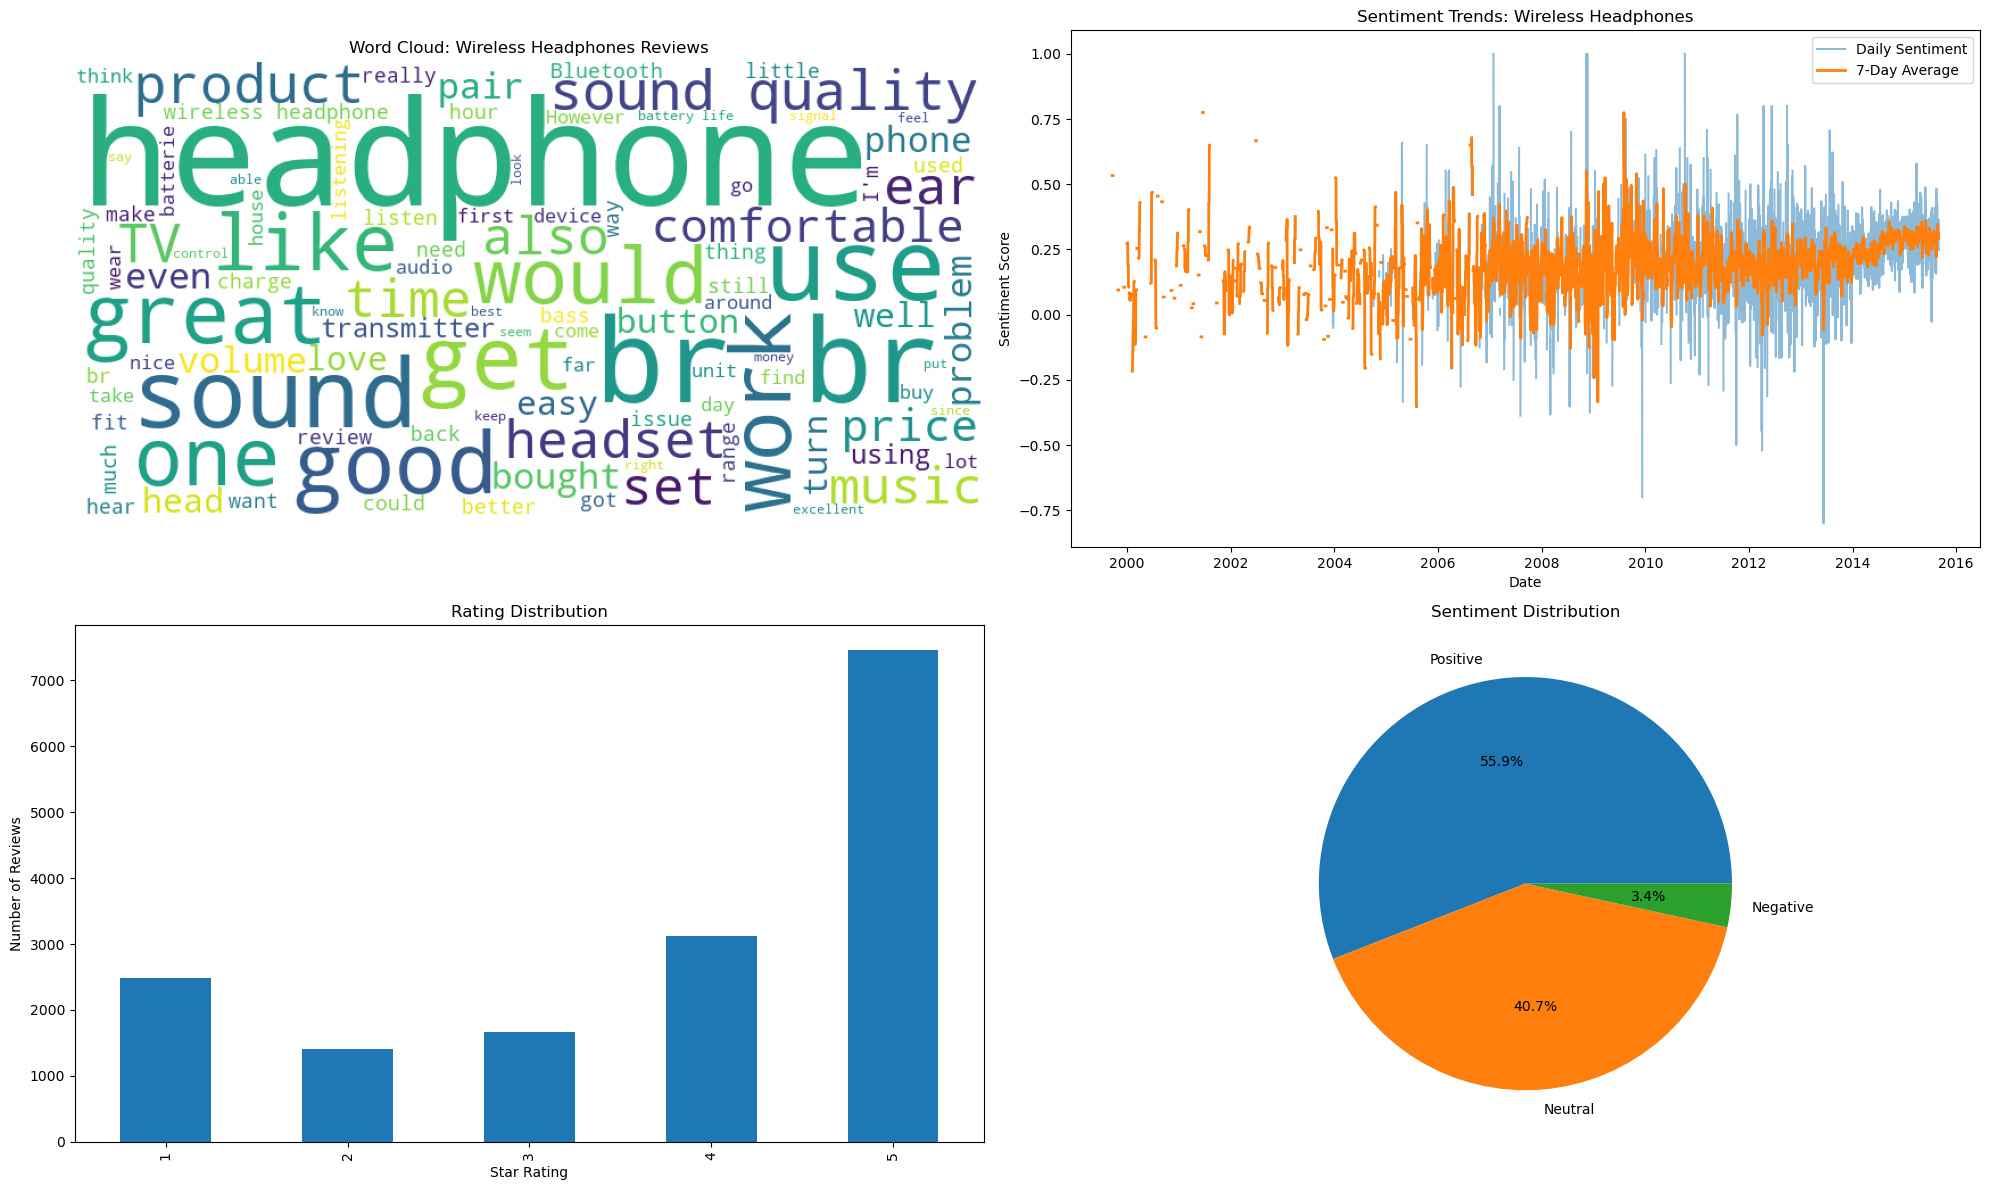

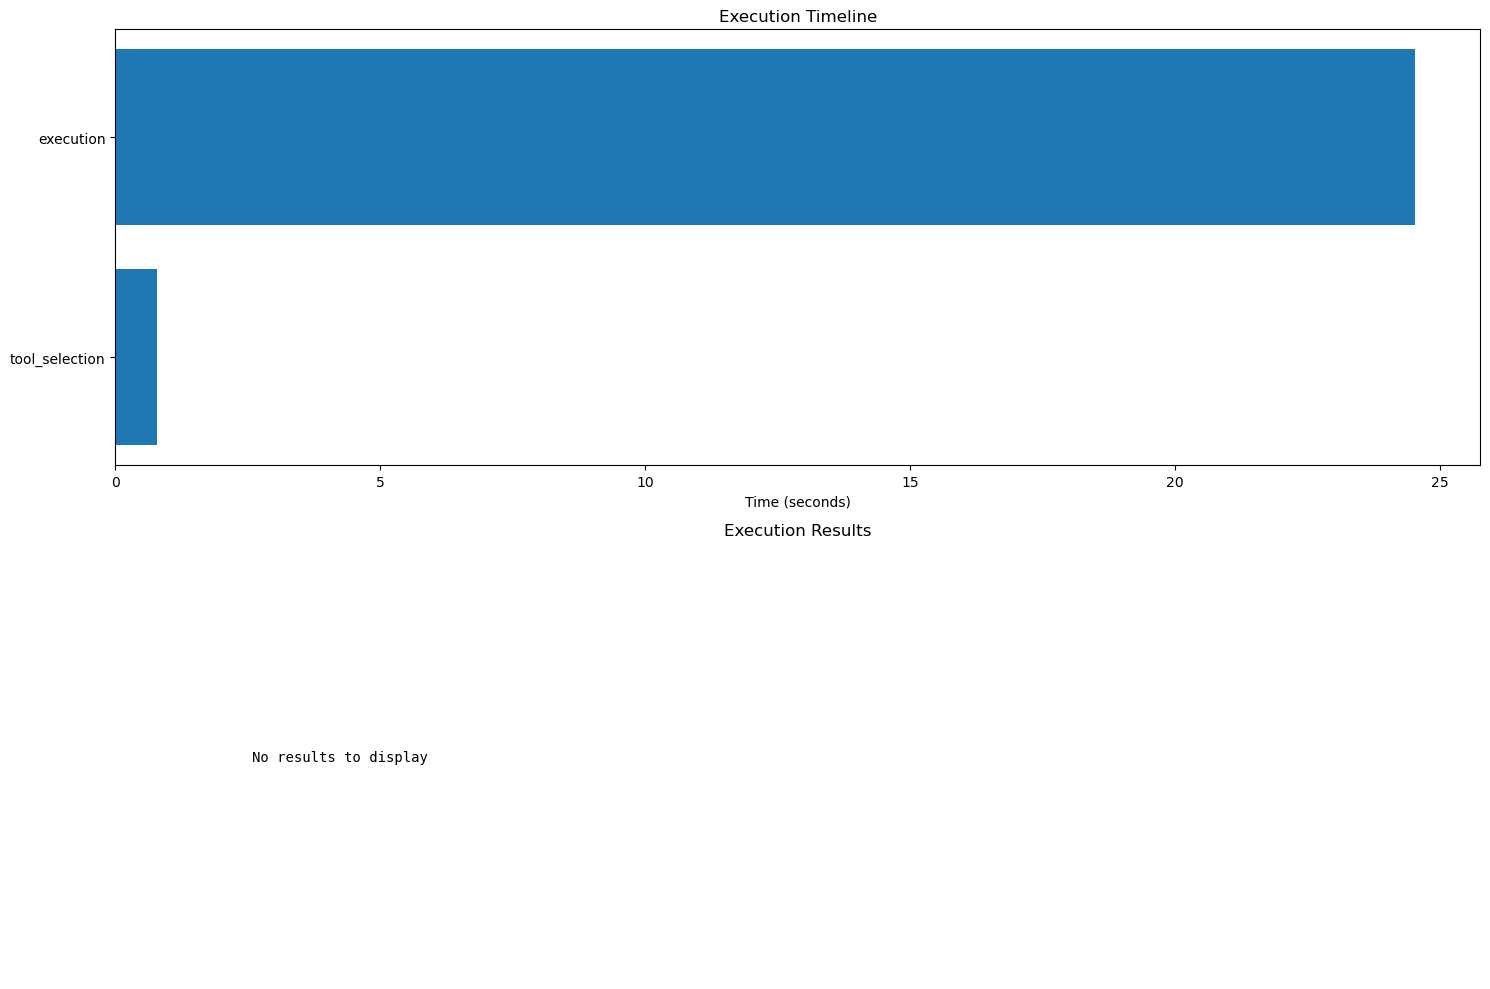

Total execution time: 25.31 seconds
--------------------------------------------------

Processing query: Show me statistics for Bluetooth speakers


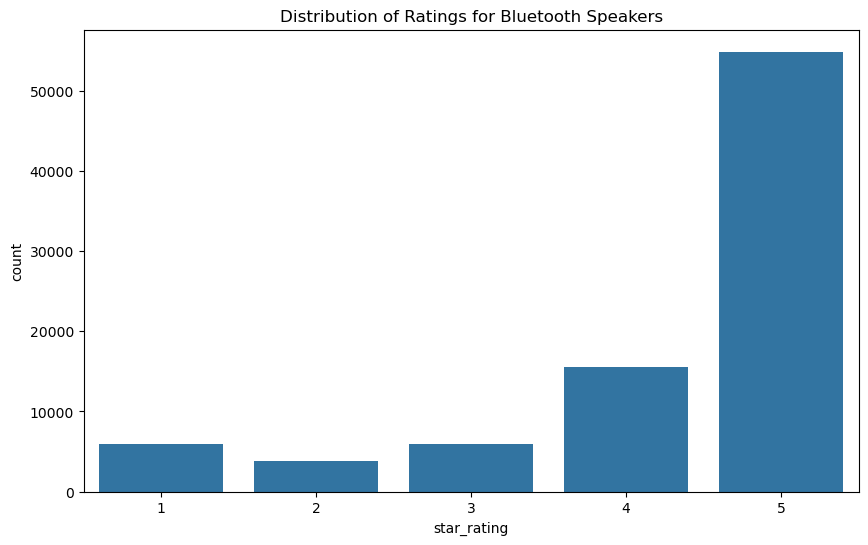

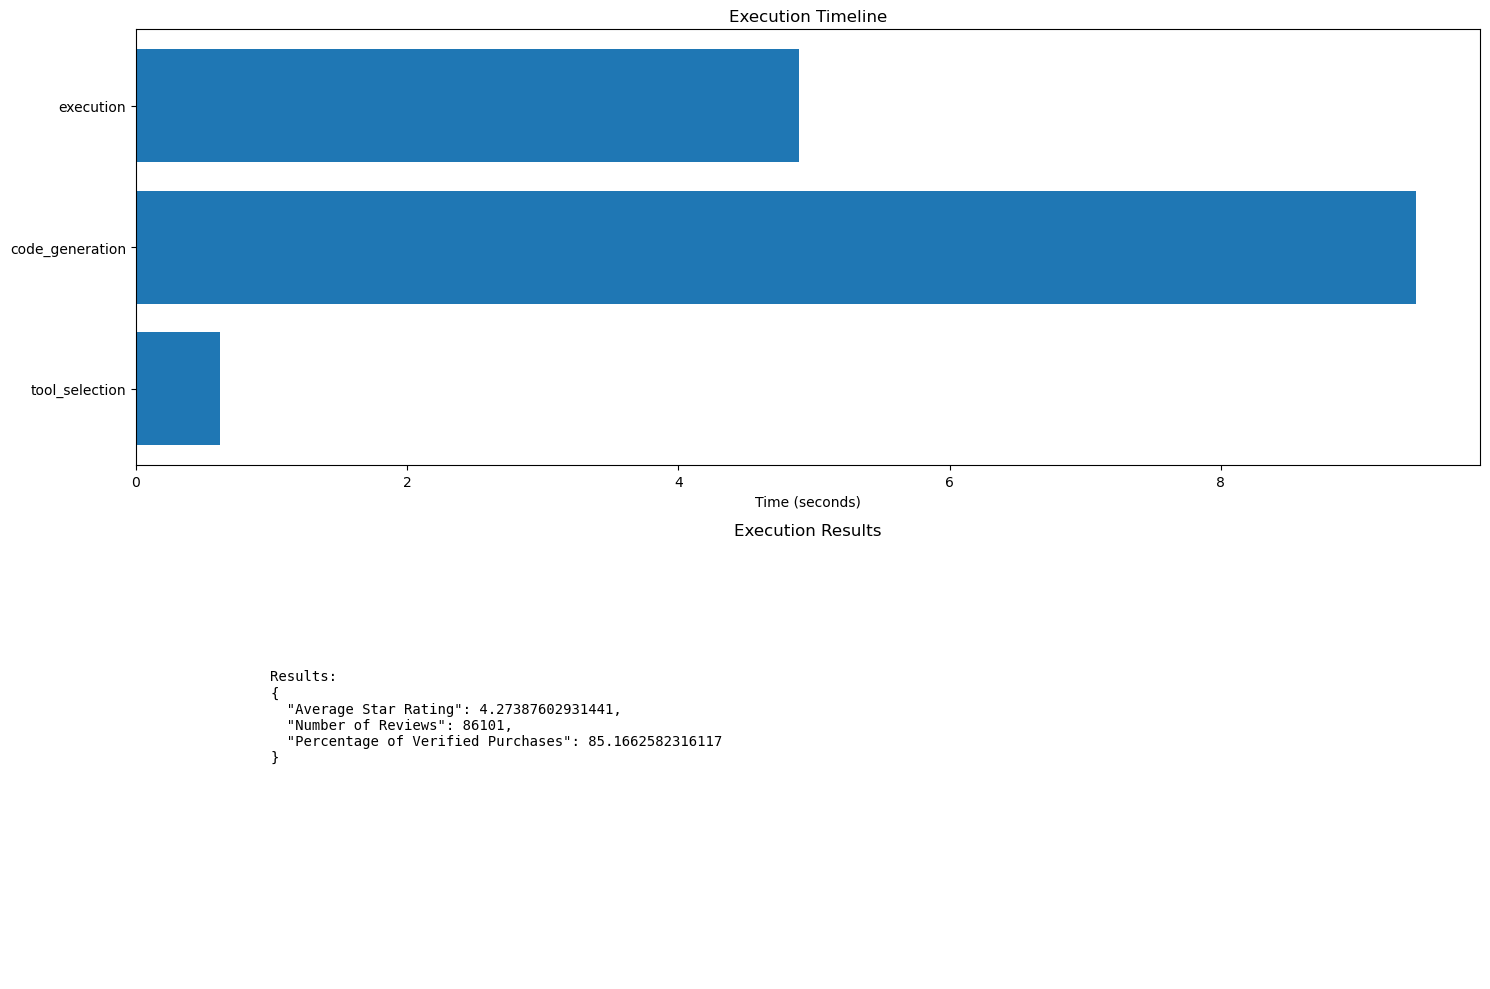

Total execution time: 14.95 seconds
--------------------------------------------------

Processing query: Compare reviews between different brands of gaming headsets


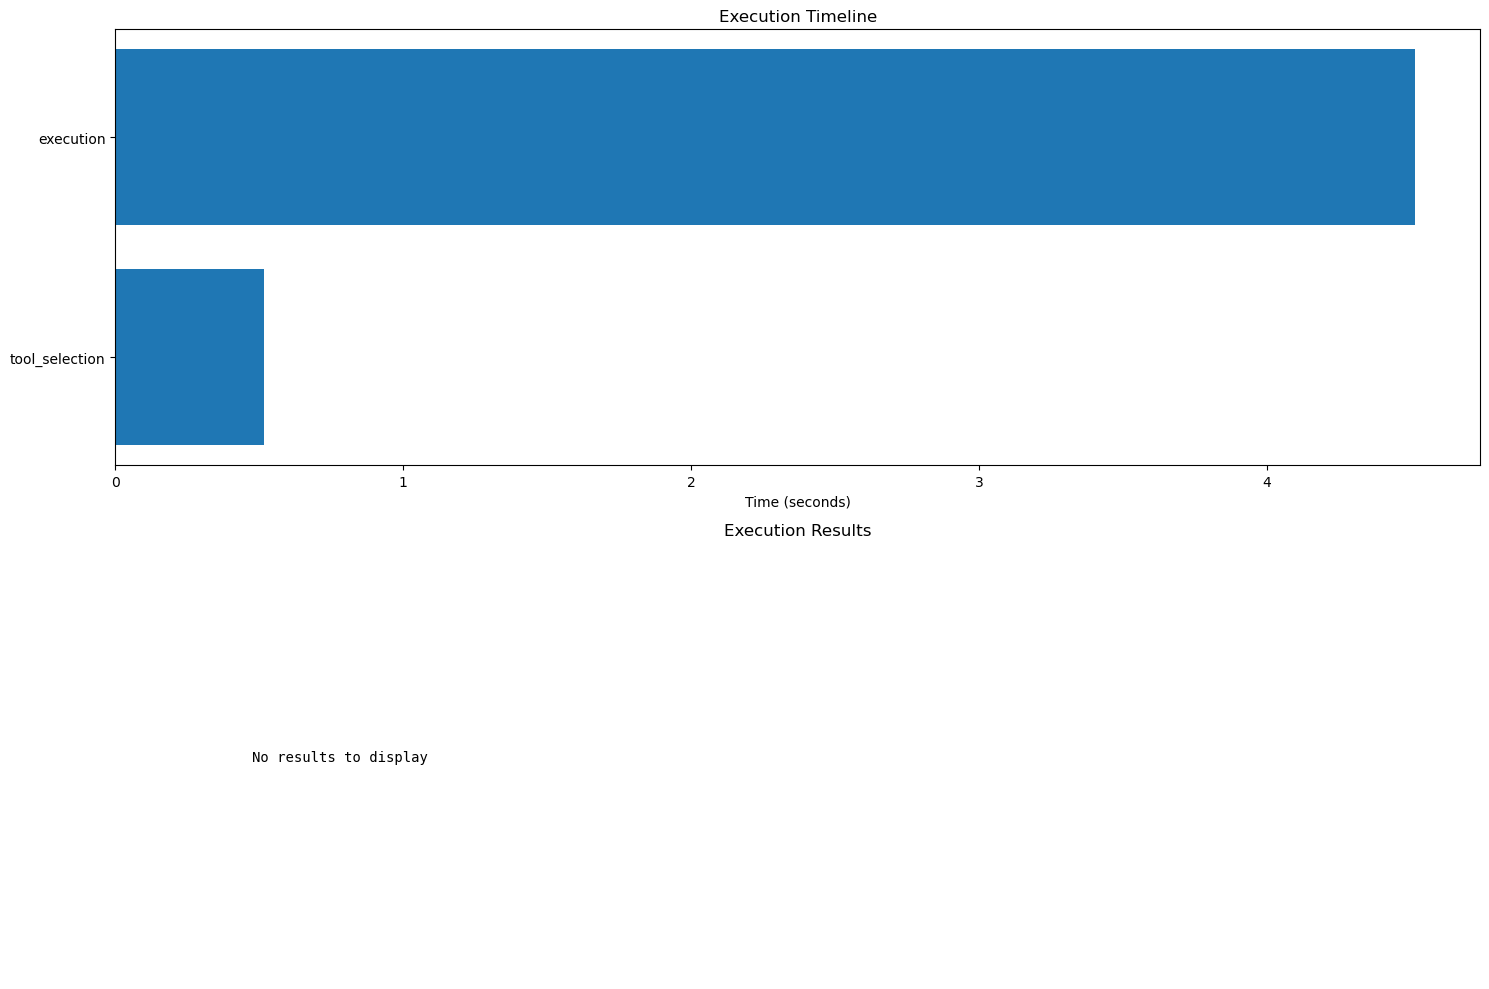

Total execution time: 5.03 seconds
--------------------------------------------------


In [22]:
# Test the fixed code
agent = CustomerSupportAgent(
    api_key='',
    dataset_path='amazon.tsv'
)

# Test queries
test_queries = [
    "Analyze customer ratings for wireless headphones",
    "Show me statistics for Bluetooth speakers",
    "Compare reviews between different brands of gaming headsets"
]

# Process each query
for query in test_queries:
    print(f"\nProcessing query: {query}")
    result = agent.process_query(query)
    
    # Show execution visualization
    agent.visualize_execution(result)
    
    # Print execution time
    total_time = sum(step.get('time', 0) for step in result.get('steps', []))
    print(f"Total execution time: {total_time:.2f} seconds")
    
    # Print any errors
    if not result.get('success', False):
        print(f"Error: {result.get('error', 'Unknown error')}")
    
    print("-" * 50)
